In [1]:
pip install transformers datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


# Preprocessing Dataset

In [3]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import time
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (replace 'petitions_filtered.csv' with your actual dataset)
df = pd.read_csv('petitions_v2.csv')

# Remove unnecessary columns (assuming 'id' column exists and needs to be removed)
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Define your updated preprocessing function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers, but add a space instead of removing
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

# Apply preprocessing to the 'action' and 'background' columns
df['action'] = df['action'].apply(preprocess_text)
df['background'] = df['background'].apply(preprocess_text)

# Combine 'action' and 'background' into a single 'text' column
df['text'] = df['action'] + " " + df['background']

# Drop 'action' and 'background' columns
df = df.drop(columns=['action', 'background'])

# Manually map department labels to numeric labels
label_mapping = {
    'Department of Health and Social Care': 0,
    'Department for Education': 1,
    'Department for Transport': 2,
    'Department for Environment, Food and Rural Affairs': 3,
    'Home Office': 4,
    'Cabinet Office': 5,
    'Department for Business, Energy and Industrial Strategy': 6,
    'HM Treasury': 7,
    'Ministry of Justice': 8,
    'Department for Work and Pensions': 9,
    'Department for Levelling Up, Housing and Communities ': 10
}

# Map department labels to numeric labels
df['label'] = df['department'].map(label_mapping)

# Display the first few rows of the preprocessed dataset
print("\nPreprocessed Dataset:")
print(df.head())

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Display the shape of the train and test sets
print(f"\nTrain set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Initialize the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')


Preprocessed Dataset:
                             department  \
0  Department of Health and Social Care   
1  Department of Health and Social Care   
2  Department of Health and Social Care   
3  Department of Health and Social Care   
4  Department of Health and Social Care   

                                                text  label  
0  hold a public inquiry into pfi and the nhs fin...      0  
1  fund free rape alarms for all the government s...      0  
2  prioritise teachers for covid booster vaccinat...      0  
3  ban advertising campaigns of processed foods t...      0  
4  add crohn s colitis to the medically exempt ce...      0  

Train set shape: (4400, 3)
Test set shape: (1100, 3)


# Define the Model

In [4]:
# # Freeze all layers except the last layer of distilbert_model
# for param in distilbert_model.parameters():
#     param.requires_grad = False

# for param in distilbert_model.transformer.layer[-1].parameters():
#     param.requires_grad = True

# Define the model class for text classification
class DistilBERTClassifier(nn.Module):
    def __init__(self, distilbert_model, num_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = distilbert_model
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output[0]  # (batch_size, seq_length, hidden_size)
        pooled_output = hidden_state[:, 0]  # (batch_size, hidden_size)
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = torch.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the DistilBERT classifier model
num_classes = len(label_mapping)  # Number of unique departments
model = DistilBERTClassifier(distilbert_model, num_classes)
model.to(device)  # Move the model to the GPU if available

# Print the model architecture
print(model)

DistilBERTClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin

# Dataset and Data Loaders

In [5]:
# Define a custom dataset class
class PetitionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LENGTH = 512  # Maximum length of input text
BATCH_SIZE = 16  # Batch size for training and evaluation


# Training Parameters

In [6]:
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
import torch.nn as nn

# Training parameters
EPOCHS = 3  # Number of training epochs
LEARNING_RATE = 1e-5  # Learning rate

# # Define the optimizer and scheduler
# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
# total_steps = len(train_loader) * EPOCHS
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )

# # Define the loss function and move it to the appropriate device
# criterion = nn.CrossEntropyLoss().to(device)


# Training and Evaluation Functions

In [7]:
# Training and evaluation functions
def train_epoch(model, data_loader, criterion, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    # Use tqdm to display a progress bar for training
    with tqdm(total=len(data_loader), desc=f'Training Epoch', unit='batch') as pbar:
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            correct_predictions += torch.sum(torch.argmax(outputs, dim=1) == labels)
            losses.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            pbar.update(1)
            pbar.set_postfix({'loss': loss.item()})

    return correct_predictions.double() / n_examples, np.mean(losses)

# Modified eval_model to return predictions and labels
def eval_model(model, data_loader, criterion, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with tqdm(total=len(data_loader), desc=f'Validation Epoch', unit='batch') as pbar:
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                correct_predictions += torch.sum(torch.argmax(outputs, dim=1) == labels)
                losses.append(loss.item())

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                labels = labels.cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels)

                pbar.update(1)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, np.mean(losses), f1, precision, recall, cm, all_preds, all_labels


# Training loop and Confusion Matrix

Fold 1/5
----------


c:\Users\kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 1.3147 accuracy 0.6282
Epoch 2/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.7370 accuracy 0.7943
Epoch 3/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.5868 accuracy 0.8377


Validation Epoch:   0%|          | 0/69 [00:00<?, ?batch/s]

Val   loss 0.8512 accuracy 0.7455 f1 0.7444 precision 0.7473 recall 0.7455
Fold 2/5
----------
Epoch 1/3
----------


c:\Users\kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.9080 accuracy 0.7609
Epoch 2/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.5075 accuracy 0.8636
Epoch 3/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.3924 accuracy 0.8998


Validation Epoch:   0%|          | 0/69 [00:00<?, ?batch/s]

Val   loss 0.5805 accuracy 0.8264 f1 0.8272 precision 0.8319 recall 0.8264
Fold 3/5
----------
Epoch 1/3
----------


c:\Users\kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.7190 accuracy 0.8355
Epoch 2/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.3501 accuracy 0.9143
Epoch 3/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.2554 accuracy 0.9409


Validation Epoch:   0%|          | 0/69 [00:00<?, ?batch/s]

Val   loss 0.3963 accuracy 0.8873 f1 0.8867 precision 0.8885 recall 0.8873
Fold 4/5
----------
Epoch 1/3
----------


c:\Users\kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.5692 accuracy 0.8789
Epoch 2/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.2356 accuracy 0.9461
Epoch 3/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.1704 accuracy 0.9609


Validation Epoch:   0%|          | 0/69 [00:00<?, ?batch/s]

Val   loss 0.2146 accuracy 0.9509 f1 0.9504 precision 0.9511 recall 0.9509
Fold 5/5
----------
Epoch 1/3
----------


c:\Users\kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.4617 accuracy 0.9127
Epoch 2/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.1628 accuracy 0.9680
Epoch 3/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

Train loss 0.1197 accuracy 0.9780


Validation Epoch:   0%|          | 0/69 [00:00<?, ?batch/s]

Val   loss 0.1625 accuracy 0.9636 f1 0.9636 precision 0.9641 recall 0.9636
Results for fold 1
Train Accuracy: [tensor(0.8377, device='cuda:0', dtype=torch.float64)]
Train Loss: [0.5867854105884378]
Validation Accuracy: [0.7454545454545455]
Validation Loss: [0.8512180285609287]
F1 Score: [0.7444286166461457]
Precision: [0.7472840932105187]
Recall: [0.7454545454545455]
Results for fold 2
Train Accuracy: [tensor(0.8998, device='cuda:0', dtype=torch.float64)]
Train Loss: [0.3923622611165047]
Validation Accuracy: [0.8263636363636364]
Validation Loss: [0.5805453152220318]
F1 Score: [0.8272069972967736]
Precision: [0.8318755551243412]
Recall: [0.8263636363636364]
Results for fold 3
Train Accuracy: [tensor(0.9409, device='cuda:0', dtype=torch.float64)]
Train Loss: [0.2554021914845163]
Validation Accuracy: [0.8872727272727273]
Validation Loss: [0.39627440743472264]
F1 Score: [0.886656684806614]
Precision: [0.888515456818142]
Recall: [0.8872727272727273]
Results for fold 4
Train Accuracy: [tenso

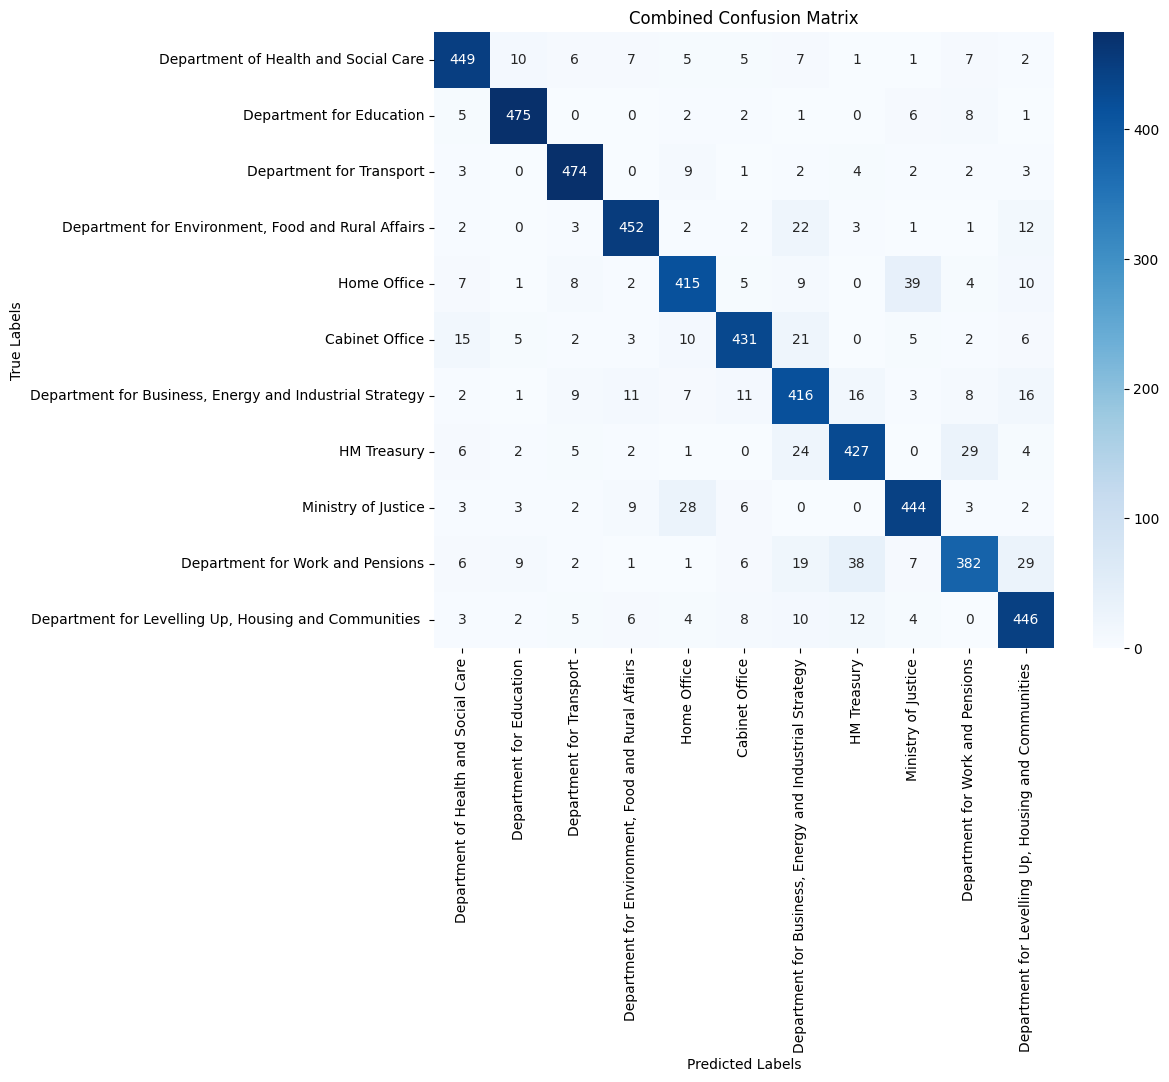

                                                         precision    recall  f1-score   support

                   Department of Health and Social Care       0.90      0.90      0.90       500
                               Department for Education       0.94      0.95      0.94       500
                               Department for Transport       0.92      0.95      0.93       500
     Department for Environment, Food and Rural Affairs       0.92      0.90      0.91       500
                                            Home Office       0.86      0.83      0.84       500
                                         Cabinet Office       0.90      0.86      0.88       500
Department for Business, Energy and Industrial Strategy       0.78      0.83      0.81       500
                                            HM Treasury       0.85      0.85      0.85       500
                                    Ministry of Justice       0.87      0.89      0.88       500
                       Depart

In [8]:
# K-Fold Cross-Validation
def k_fold_cross_validation(model_class, tokenizer, df, label_mapping, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []
    best_accuracy = 0
    best_model_state = None
    all_preds = []
    all_labels = []

    for fold, (train_index, val_index) in enumerate(kf.split(df)):
        print(f'Fold {fold + 1}/{k}')
        print('-' * 10)

        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]

        train_dataset = PetitionDataset(
            texts=train_df['text'].tolist(),
            labels=train_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )

        val_dataset = PetitionDataset(
            texts=val_df['text'].tolist(),
            labels=val_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

        model = model_class(distilbert_model, len(label_mapping))
        model.to(device)

        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
        total_steps = len(train_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        criterion = nn.CrossEntropyLoss().to(device)

        history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': [], 'f1': [], 'precision': [], 'recall': []}
        best_fold_accuracy = 0

        for epoch in range(EPOCHS):
            print(f'Epoch {epoch + 1}/{EPOCHS}')
            print('-' * 10)

            train_acc, train_loss = train_epoch(
                model,
                train_loader,
                criterion,
                optimizer,
                device,
                scheduler,
                len(train_dataset)
            )

            print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

        # Evaluate the model at the end of each fold
        val_acc, val_loss, val_f1, val_precision, val_recall, cm, fold_preds, fold_labels = eval_model(
            model,
            val_loader,
            criterion,
            device,
            len(val_dataset)
        )

        all_preds.extend(fold_preds)
        all_labels.extend(fold_labels)

        print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f} f1 {val_f1:.4f} precision {val_precision:.4f} recall {val_recall:.4f}')

        history['train_acc'].append(train_acc)  # No .item() needed
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['f1'].append(val_f1)
        history['precision'].append(val_precision)
        history['recall'].append(val_recall)

        # Save the best model for the current fold
        if val_acc > best_fold_accuracy:
            best_fold_accuracy = val_acc
            torch.save(model.state_dict(), f'best_model_state_fold_{fold + 1}.bin')

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_state = model.state_dict()

        results.append(history)

    # Save the overall best model
    if best_model_state:
        torch.save(best_model_state, 'best_model_state.bin')

    return results, all_preds, all_labels



# Run K-Fold Cross-Validation
results, all_preds, all_labels = k_fold_cross_validation(DistilBERTClassifier, tokenizer, df, label_mapping, k=5)

# Print the results
for i, history in enumerate(results):
    print(f'Results for fold {i + 1}')
    print(f"Train Accuracy: {history['train_acc']}")
    print(f"Train Loss: {history['train_loss']}")
    print(f"Validation Accuracy: {history['val_acc']}")
    print(f"Validation Loss: {history['val_loss']}")
    print(f"F1 Score: {history['f1']}")
    print(f"Precision: {history['precision']}")
    print(f"Recall: {history['recall']}")

# Combine confusion matrix across all folds
combined_cm = confusion_matrix(all_labels, all_preds)

# Map numerical labels back to text labels
label_mapping_reverse = {v: k for k, v in label_mapping.items()}
label_names = [label_mapping_reverse[i] for i in range(len(label_mapping))]

# Plot the combined confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=label_names)

# Print the classification report
print(report)

In [17]:
# Load the best model state
best_model = DistilBERTClassifier(distilbert_model, num_classes)
best_model.load_state_dict(torch.load('best_model_state.bin'))
best_model.to(device)
best_model.eval()

# Example of using the best model for prediction
def predict(text):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    with torch.no_grad():
        output = best_model(input_ids=input_ids, attention_mask=attention_mask)

    probabilities = torch.softmax(output, dim=1).squeeze()
    predicted_class = torch.argmax(probabilities).item()
    predicted_department = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_class)]

    return predicted_department, probabilities[predicted_class].item()

# Example usage:
text = "Ban full face covers in public such as balaclavas"
predicted_department, confidence = predict(text)
print(f"Predicted Department: {predicted_department}")
print(f"Confidence: {confidence:.4f}")


Predicted Department: Cabinet Office
Confidence: 0.3333


In [ ]:
# Load the best model state
best_model = DistilBERTClassifier(distilbert_model, num_classes)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_state.bin', map_location=device))
best_model.to(device)
best_model.eval()

# Define the prediction function
def predict(text):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,  # Adjust if necessary
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    with torch.no_grad():
        output = best_model(input_ids=input_ids, attention_mask=attention_mask)

    probabilities = torch.softmax(output, dim=1).squeeze()
    predicted_class = torch.argmax(probabilities).item()
    predicted_department = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_class)]

    return predicted_department, probabilities[predicted_class].item()

# Example usage
text = "I want to reduce taxes for foods"
predicted_department, confidence = predict(text)
print(f"Predicted Department: {predicted_department}")
print(f"Confidence: {confidence:.4f}")

Predicted Department: Cabinet Office
Confidence: 0.9974


# Graphs


In [ ]:
pip install matplotlib


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store data for all folds
train_acc_all_folds = []
val_acc_all_folds = []
train_loss_all_folds = []
val_loss_all_folds = []

# Collect data from each fold
for history in results:
    # Extract tensors from the history dictionary and move to CPU
    train_acc_all_folds.append(np.array(history['train_acc'][0].cpu()))  # Convert to numpy array after moving to CPU
    val_acc_all_folds.append(np.array(history['val_acc'][0].cpu()))  # Convert to numpy array after moving to CPU
    train_loss_all_folds.append(np.array(history['train_loss'][0].cpu()))
    val_loss_all_folds.append(np.array(history['val_loss'][0].cpu()))

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
for i in range(len(train_acc_all_folds)):
    plt.plot(train_acc_all_folds[i], label=f'Train Fold {i + 1}')
    plt.plot(val_acc_all_folds[i], label=f'Val Fold {i + 1}', linestyle='--')
plt.title('Training and Validation Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
for i in range(len(train_loss_all_folds)):
    plt.plot(train_loss_all_folds[i], label=f'Train Fold {i + 1}')
    plt.plot(val_loss_all_folds[i], label=f'Val Fold {i + 1}', linestyle='--')
plt.title('Training and Validation Loss Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'float' object has no attribute 'cpu'